In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('Fraud.csv')



In [2]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

print("After encoding 'type':")
print(df['type'].unique())
print(df.dtypes)

After encoding 'type':
[3 4 1 2 0]
step                int64
type                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [5]:
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('isFraud') 
print("Numeric columns to analyze:")
print(numeric_cols)

Numeric columns to analyze:
['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


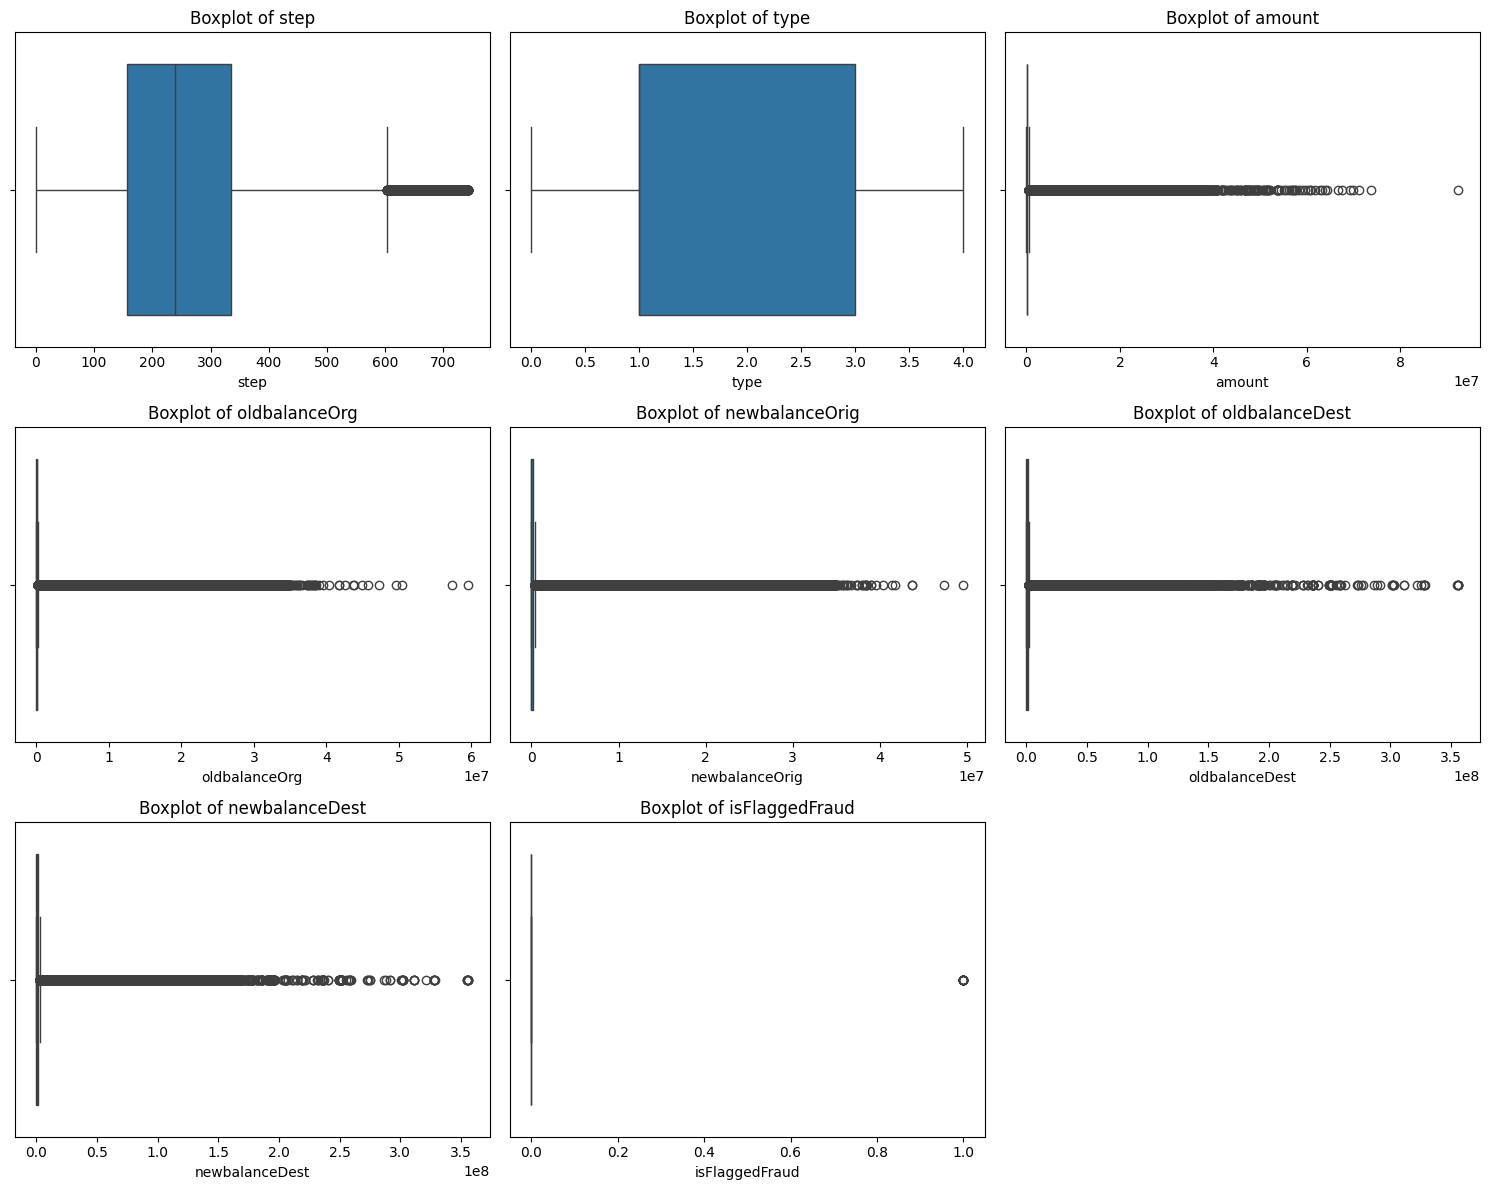

In [7]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_features = df.drop('isFraud', axis=1)

In [9]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_features.columns
vif_data["VIF"] = [variance_inflation_factor(X_features.values, i) for i in range(X_features.shape[1])]

print(vif_data)

          Feature         VIF
0            step    2.235192
1            type    2.075263
2          amount    4.015720
3   oldbalanceOrg  480.228469
4  newbalanceOrig  483.731350
5  oldbalanceDest   72.097182
6  newbalanceDest   83.582019
7  isFlaggedFraud    1.000571


In [10]:
df_cleaned = df.drop(['newbalanceOrig', 'newbalanceDest'], axis=1)

print("Columns after dropping highly correlated ones:")
print(df_cleaned.columns)


Columns after dropping highly correlated ones:
Index(['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop('isFraud', axis=1)
y = df_cleaned['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,random_state=42,stratify=y)

In [12]:
print(X_train.shape)

(5726358, 6)


In [13]:
print(X_test.shape)

(636262, 6)


In [14]:
print(y_train.shape)

(5726358,)


In [15]:
print(y_test.shape)

(636262,)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [17]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [18]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    635441
           1       0.01      0.69      0.02       821

    accuracy                           0.89    636262
   macro avg       0.50      0.79      0.48    636262
weighted avg       1.00      0.89      0.94    636262



In [20]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"logistic regrr. ROC AUC Score: {auc:.4f}")

logistic regrr. ROC AUC Score: 0.8325


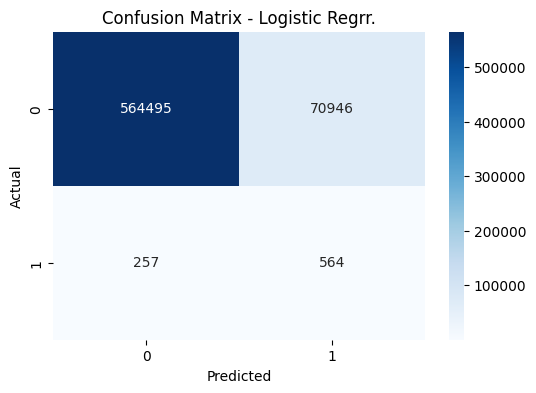

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regrr.')
plt.show()

In [22]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)


          Feature   Coefficient
1            type  2.847454e-01
5  isFlaggedFraud  4.898228e-03
0            step  3.601869e-03
2          amount  2.062981e-06
3   oldbalanceOrg -1.085525e-07
4  oldbalanceDest -1.132652e-07


In [23]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [24]:
y_pred_proba = dtree.predict_proba(X_test)[:,1]
y_pred = dtree.predict(X_test)

In [25]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Decision Tree ROC AUC: {auc:.4f}")


Decision Tree ROC AUC: 0.8665


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.81      0.73      0.77       821

    accuracy                           1.00    636262
   macro avg       0.91      0.87      0.89    636262
weighted avg       1.00      1.00      1.00    636262



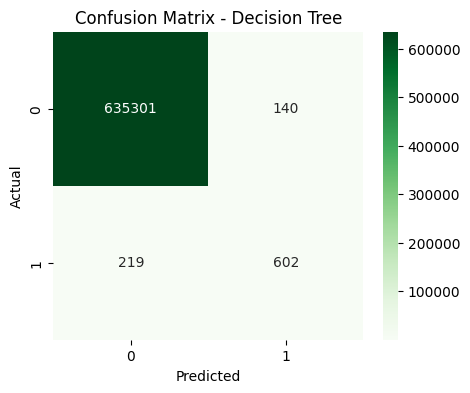

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [29]:
y_pred_proba = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)

In [30]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Random Forest ROC AUC: {auc:.4f}")
print(classification_report(y_test, y_pred))

Random Forest ROC AUC: 0.9892
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.94      0.69      0.79       821

    accuracy                           1.00    636262
   macro avg       0.97      0.84      0.90    636262
weighted avg       1.00      1.00      1.00    636262



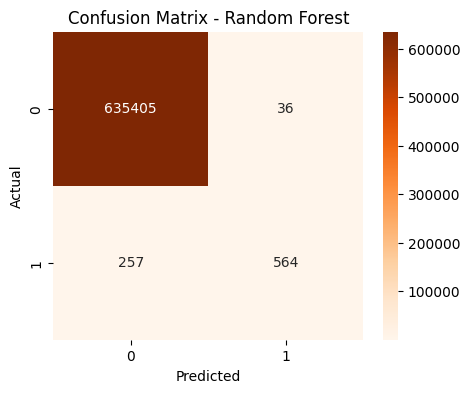

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Text(0, 0.5, 'ROC AUC Score')

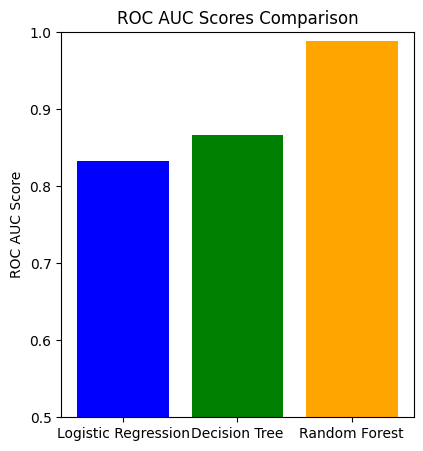

In [32]:
import matplotlib.pyplot as plt
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
roc_aucs = [0.8325, 0.8665, 0.9892] 
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(model_names, roc_aucs, color=['blue', 'green', 'orange'])
plt.title('ROC AUC Scores Comparison')
plt.ylim(0.5,1)
plt.ylabel('ROC AUC Score')

In [33]:
final_preds = rf.predict(X_test)
final_pred_proba = rf.predict_proba(X_test)[:,1]


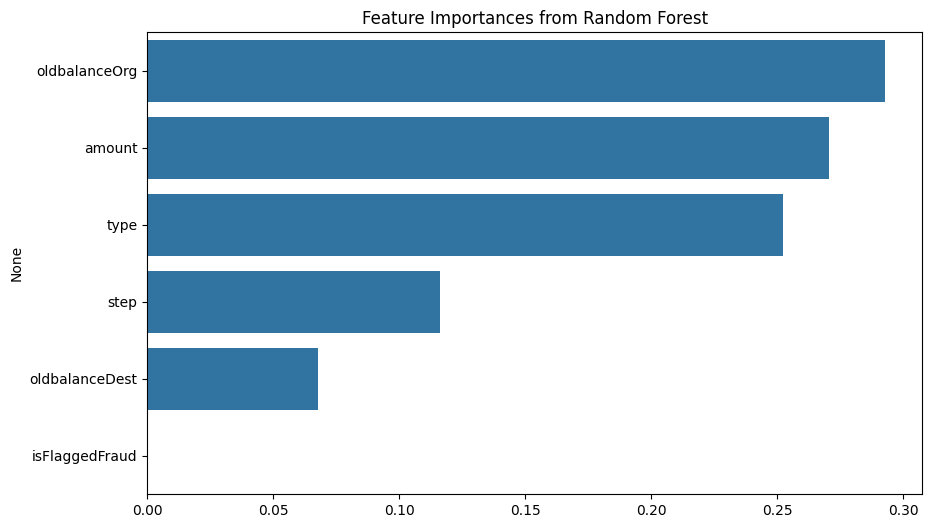

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Feature Importances from Random Forest')
plt.show()


In [35]:
def predict_fraud_rf():
    step = int(input("step (int): "))
    type_ = int(input("type (encoded as int): "))
    amount = float(input("amount: "))
    oldbalanceOrg = float(input("oldbalanceOrg: "))
    oldbalanceDest = float(input("oldbalanceDest: "))
    isFlaggedFraud = int(input("isFlaggedFraud (0 or 1): "))
    
    input_df = pd.DataFrame({
        'step': [step],
        'type': [type_],
        'amount': [amount],
        'oldbalanceOrg': [oldbalanceOrg],
        'oldbalanceDest': [oldbalanceDest],
        'isFlaggedFraud': [isFlaggedFraud]
    })
    
    pred_class = rf.predict(input_df)[0]
    pred_prob = rf.predict_proba(input_df)[0][1] 
    
    
    print(f"\nRandom Forest Prediction:")
    print(f"Class (0=Not Fraud, 1=Fraud): {pred_class}")
    print(f"Fraud Probability: {pred_prob:.4f}")
    
predict_fraud_rf()   

step (int): 10
type (encoded as int): 1
amount: 5000.00
oldbalanceOrg: 1000.00
oldbalanceDest: 20000.00
isFlaggedFraud (0 or 1): 1

Random Forest Prediction:
Class (0=Not Fraud, 1=Fraud): 0
Fraud Probability: 0.0000
